# Evictions in LA 2023

In [4]:
pip install pygris

  Using cached pygris-0.1.6-py3-none-any.whl.metadata (2.5 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
Using cached pygris-0.1.6-py3-none-any.whl (55 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install bambi

  Using cached bambi-0.13.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached arviz-0.17.1-py3-none-any.whl.metadata (8.7 kB)
  Using cached formulae-0.5.3-py3-none-any.whl.metadata (4.5 kB)
  Using cached graphviz-0.20.2-py3-none-any.whl.metadata (12 kB)
  Using cached pymc-5.11.0-py3-none-any.whl.metadata (10 kB)
  Using cached xarray-2024.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached h5netcdf-1.3.0-py3-none-any.whl.metadata (13 kB)
  Using cached xarray_einstats-0.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached pytensor-2.18.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached etuples-0.3.9-py3-none-any.whl
  Using cached logical_unification-0.4.6-py3-none-any.whl
  Using cached miniKanren-1.0.3-py3-none-any.whl
  Using cached cons-0.4.6-py3-none-any.whl
  Using cached multipledispatch-1.0.0-py3-n

## Import

In [6]:
import pandas as pd
import geopandas as gpd 
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from libpysal.weights import KNN
import esda
from esda.moran import Moran
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal
import seaborn as sns
import contextily
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.formula.api import glm
from patsy import dmatrices
from pygris import tracts
import bambi as bmb
import arviz as az


In [7]:

evictions = pd.read_csv('data/2023_eviction_filings_final.csv')
evictions_geocoded = pd.read_csv('data/evictions_geocoded.csv')
svi_la = pd.read_csv('data/SVI_la.csv',dtype={'FIPS':str})
rent_df = pd.read_csv('data/ACSST5Y2020.S2502-Data.csv',dtype={'FIPS':str})


In [8]:

gdf_ct = tracts(state='California',county='Los Angeles')

Using the default year of 2021
Using FIPS code '06' for input 'California'
Using FIPS code '037' for input 'Los Angeles'


## Cleaning

In [9]:

# Convert evictions 'Address' to string
evictions['Address'] = evictions['Address'].astype(str)

# Create new column in evictions_geocode with matching name 'Address' and make sure it's a string
evictions_geocoded['Address'] = evictions_geocoded['input_string'].astype(str)
evictions_geocoded = gpd.GeoDataFrame(evictions_geocoded,geometry=gpd.points_from_xy(evictions_geocoded['longitude'],evictions_geocoded['latitude']),crs='4326')
evics = evictions_geocoded.merge(evictions,left_index=True,right_index=True)
evics = evics.to_crs(epsg='3857')




In [10]:
rent_df = rent_df[['FIPS','S2502_C05_001E']]
rent_df = rent_df.rename(columns={'S2502_C05_001E':'renter_occupied'})

In [11]:
gdf_ct.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
223,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,+34.1661153,-118.6402345,"POLYGON ((-118.65862 34.17142, -118.65849 34.1..."
415,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,+33.8993442,-118.2100023,"POLYGON ((-118.21630 33.90339, -118.21538 33.9..."
416,06,037,541801,06037541801,5418.01,Census Tract 5418.01,G5020,S,714942,0,+33.9118044,-118.1946754,"POLYGON ((-118.19998 33.90668, -118.19878 33.9..."
427,06,037,541802,06037541802,5418.02,Census Tract 5418.02,G5020,S,1110125,0,+33.9098797,-118.1866746,"POLYGON ((-118.19359 33.90654, -118.19343 33.9..."
428,06,037,542000,06037542000,5420,Census Tract 5420,G5020,S,974029,0,+33.9055708,-118.2031580,"POLYGON ((-118.20734 33.90732, -118.20733 33.9..."


In [12]:
svi_la = svi_la[svi_la['COUNTY'] == 'Los Angeles']

<Axes: >

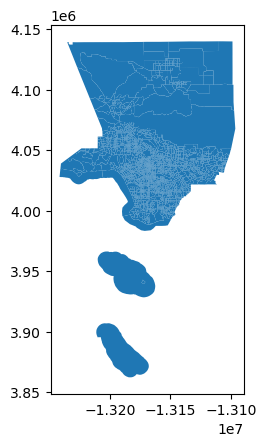

In [13]:
gdf_ct = gdf_ct.to_crs(epsg='3857')

# trim the data to the bare minimum columns
gdf_ct = gdf_ct[['GEOID','geometry']]

# rename the columns
gdf_ct.columns = ['FIPS','geometry']
# last rows
gdf_ct.plot()



In [14]:
svi_la['FIPS'].isin(gdf_ct['FIPS'])

1378    True
1379    True
1380    True
1381    True
1382    True
        ... 
3868    True
3869    True
3870    True
3871    True
3872    True
Name: FIPS, Length: 2495, dtype: bool

### Process and merge dataframes

In [62]:
# Merge tract geo data with social vulnerability index data
gdf_ct = gdf_ct.merge(svi_la,on='FIPS')

# Select and rename columns
gdf_ct = gdf_ct.loc[:, ['FIPS','E_TOTPOP', 'E_HU', 'E_HH', 'EP_POV150', 'EP_UNEMP','EP_NOHSDP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ', 'geometry']]
gdf_ct = gdf_ct.rename(
    columns={'E_TOTPOP':'total_pop','E_HU':'housing_units','E_HH':'households','EP_POV150':'pov_below150','EP_UNEMP':'unemployed','EP_PCI':'cost_burdened_low_income','EP_NOHSDP':'no_high_school','EP_AGE65':'persons_over65','EP_AGE17':'persons_under17','EP_DISABL':'disabled_pop','EP_SNGPNT':'single_parent','EP_MINRTY':'minority_pop','EP_LIMENG':'limited_eng','EP_MUNIT':'10_units_plus','EP_MOBILE':'mobile_homes','EP_CROWD':'crowded_units','EP_NOVEH':'no_vehicle','EP_GROUPQ':'persons_group_quarters'
})

# Join cleaned up dataset with evictions using spatial join. Also create a new column of 'evictions_count' to count per tract
join = gdf_ct.sjoin(evics)
evics_ct = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='evictions_count')
gdf_ct=gdf_ct.merge(evics_ct,on='FIPS')

# Merge our dataframe with dataset containing total number of rental units per census tract
gdf_ct = gdf_ct.merge(rent_df,on='FIPS')

# Remove tracts without rental units and scale by 1000 
gdf_ct = gdf_ct[gdf_ct['renter_occupied']>0]
gdf_ct['count_norm'] = gdf_ct['evictions_count'] / gdf_ct['renter_occupied'] * 1000
gdf_ct

,FIPS,total_pop,housing_units,households,pov_below150,unemployed,no_high_school,persons_over65,persons_under17,disabled_pop,...,limited_eng,10_units_plus,mobile_homes,crowded_units,no_vehicle,persons_group_quarters,geometry,evictions_count,renter_occupied,count_norm
0,06037137000,5184,1842,1783,8.6,8.4,4.2,25.8,19.3,16.2,...,4.1,3.6,4.5,0.5,1.4,0.7,"POLYGON ((-13209016.934 4051842.700, -13209002...",5,341,14.662757
1,06037541605,5069,1456,1404,37.7,8.6,45.6,10.0,20.0,11.7,...,17.5,2.3,5.1,19.3,4.5,0.7,"POLYGON ((-13159778.097 4015837.431, -13159675...",2,780,2.564103
2,06037503301,3560,1056,1011,8.8,4.3,5.0,14.3,22.8,8.1,...,1.2,0.0,0.0,1.5,4.5,0.0,"POLYGON ((-13138507.725 4021922.075, -13138448...",1,136,7.352941
3,06037542601,3539,810,757,42.9,5.8,44.1,5.8,31.1,7.7,...,21.4,19.9,4.1,37.6,7.3,0.1,"POLYGON ((-13161585.369 4016310.225, -13161523...",11,543,20.257827
4,06037609900,2015,670,644,25.1,5.5,20.6,25.2,18.7,15.0,...,8.3,5.7,0.0,6.4,7.1,12.8,"POLYGON ((-13170113.444 3993675.714, -13170113...",1,325,3.076923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,06037980015,993,476,444,46.5,10.5,22.9,3.0,24.8,9.7,...,7.1,70.4,0.0,13.7,2.9,3.3,"POLYGON ((-13170262.055 3997538.878, -13170234...",70,444,157.657658
1148,06037262601,3478,1363,1290,2.6,4.0,4.1,21.6,23.1,3.7,...,1.0,1.2,1.2,1.2,0.5,0.0,"POLYGON ((-13199770.514 4039574.942, -13199705...",9,115,78.260870
1149,06037189600,3825,2296,1985,18.9,4.6,5.4,8.4,10.4,6.2,...,3.3,45.8,0.0,3.1,7.3,0.8,"POLYGON ((-13173212.467 4043362.768, -13173207...",78,1278,61.032864
1150,06037189400,3145,2039,1531,6.4,7.5,0.8,12.1,16.6,3.5,...,0.7,5.6,0.0,0.0,2.7,0.5,"POLYGON ((-13172074.670 4043733.042, -13172072...",15,658,22.796353


### Preliminary visualization of outcome variable

In [63]:
gdf_ct.columns.to_list()

['FIPS',
 'total_pop',
 'housing_units',
 'households',
 'pov_below150',
 'unemployed',
 'no_high_school',
 'persons_over65',
 'persons_under17',
 'disabled_pop',
 'single_parent',
 'minority_pop',
 'limited_eng',
 '10_units_plus',
 'mobile_homes',
 'crowded_units',
 'no_vehicle',
 'persons_group_quarters',
 'geometry',
 'evictions_count',
 'renter_occupied',
 'count_norm']

Non parametric testing because of difference in mean and median

## Data Exploration

In [64]:
gdf_ct['count_norm'].describe()

count    1152.000000
mean       78.753846
std       144.476015
min         0.464900
25%        18.703974
50%        35.794363
75%        77.653651
max      2372.881356
Name: count_norm, dtype: float64

### Scale data using a min max scaler

In [65]:
census_vars = [
 'pov_below150',
 'unemployed',
 'no_high_school',
 'minority_pop',
 '10_units_plus',
 'mobile_homes',
 'crowded_units',
 'renter_occupied',
 'count_norm',
 'single_parent',
 'limited_eng'
]

In [66]:
scaler = MinMaxScaler()
std_scaler = StandardScaler()
gdf_ct[census_vars] = std_scaler.fit_transform(gdf_ct[census_vars])


In [67]:
table = gdf_ct.describe()
table

,total_pop,housing_units,households,pov_below150,unemployed,no_high_school,persons_over65,persons_under17,disabled_pop,single_parent,minority_pop,limited_eng,10_units_plus,mobile_homes,crowded_units,no_vehicle,persons_group_quarters,evictions_count,renter_occupied,count_norm
count,1152.000000,1152.000000,1152.000000,1.152000e+03,1.152000e+03,1.152000e+03,1152.000000,1152.000000,1152.000000,1.152000e+03,1.152000e+03,1.152000e+03,1.152000e+03,1.152000e+03,1.152000e+03,1152.000000,1152.000000,1152.000000,1152.000000,1.152000e+03
mean,3661.826389,1401.551215,1298.629340,8.789266e-17,-8.480870e-18,1.757853e-16,13.117014,19.721354,10.465625,-6.167906e-18,-1.912051e-16,2.004569e-16,6.167906e-18,-1.541976e-17,-1.048544e-16,12.057465,1.930469,66.581597,0.000000,-1.017704e-16
std,1200.332323,532.903848,478.579269,1.000434e+00,1.000434e+00,1.000434e+00,6.365104,7.925252,4.717879,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,11.130844,7.848178,130.334364,1.000434,1.000434e+00
min,65.000000,17.000000,17.000000,-1.704455e+00,-1.674378e+00,-1.323657e+00,0.000000,0.000000,0.000000,-1.105413e+00,-2.475834e+00,-1.286556e+00,-1.171205e+00,-2.598014e-01,-1.184493e+00,0.000000,0.000000,1.000000,-1.734417,-5.421173e-01
25%,2809.000000,1042.750000,971.750000,-8.103697e-01,-6.143135e-01,-9.069916e-01,8.600000,14.700000,7.700000,-6.935091e-01,-8.466203e-01,-8.858118e-01,-8.751317e-01,-2.598014e-01,-8.483794e-01,4.500000,0.000000,10.000000,-0.695848,-4.158196e-01
50%,3530.000000,1338.000000,1246.500000,-1.640237e-01,-1.324662e-01,-1.540174e-01,12.200000,19.800000,9.800000,-2.215356e-01,2.939251e-01,-1.598922e-01,-2.426124e-01,-2.598014e-01,-2.265700e-01,9.100000,0.200000,26.000000,-0.108550,-2.974760e-01
75%,4446.500000,1679.000000,1544.250000,6.983002e-01,3.975659e-01,8.310990e-01,16.700000,25.100000,12.425000,4.220647e-01,9.257585e-01,6.828158e-01,7.322412e-01,-2.598014e-01,6.893384e-01,16.200000,1.025000,65.000000,0.605061,-7.618375e-03
max,9559.000000,4733.000000,4424.000000,4.304815e+00,8.829894e+00,3.045379e+00,53.200000,50.800000,60.800000,1.293365e+01,1.120463e+00,4.493321e+00,2.193260e+00,1.060753e+01,4.294152e+00,86.400000,96.400000,1554.000000,6.759821,1.588585e+01


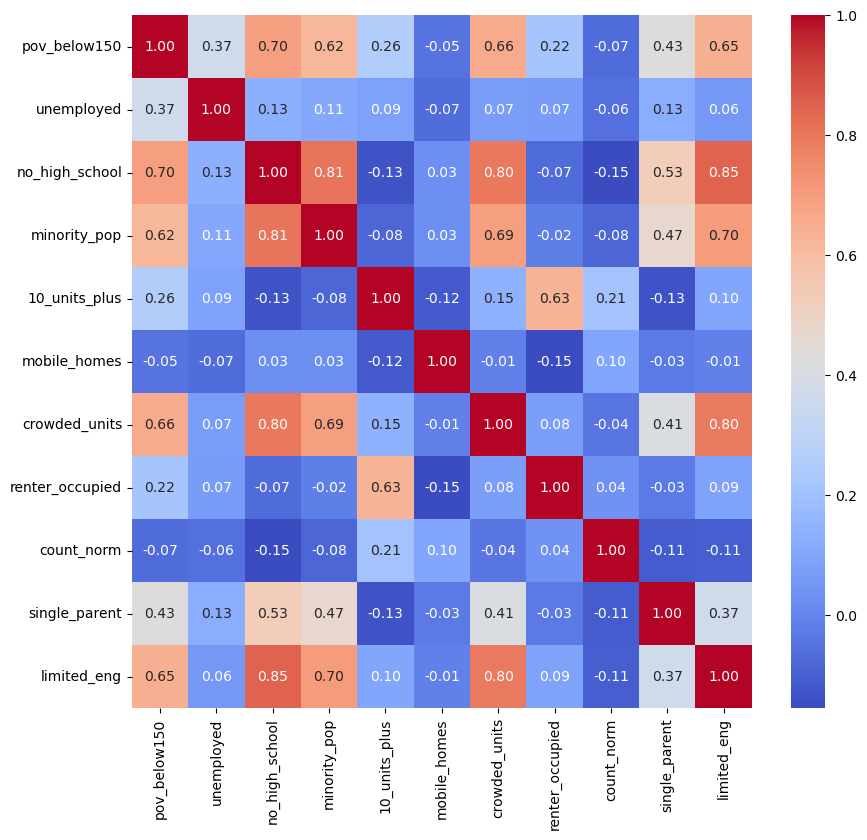

In [68]:

corr = gdf_ct[census_vars].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr,annot=True,cmap='coolwarm',fmt='.2f')
plt.show()

## We want to see how our variables interconnect. This heatmap provides some insight on preliminary findings
- We see that higher minority population tends to also be below the poverty line.
- We also that a higher minority population tends to live in crowded units
- Additionally, we see  that crowded unit occupants tend to speak limited english

### Calculate variance inflation factor for each variable considering high collinearity based on data exploration

In [69]:
C = add_constant(gdf_ct[census_vars])

vif = pd.Series([variance_inflation_factor(C.values,i) for i in range(C.shape[1])],index=C.columns)
vif

const              1.000000
pov_below150       3.207231
unemployed         1.259022
no_high_school     8.571365
minority_pop       3.030856
10_units_plus      2.478644
mobile_homes       1.047760
crowded_units      3.712316
renter_occupied    1.735720
count_norm         1.112078
single_parent      1.491786
limited_eng        4.776621
dtype: float64

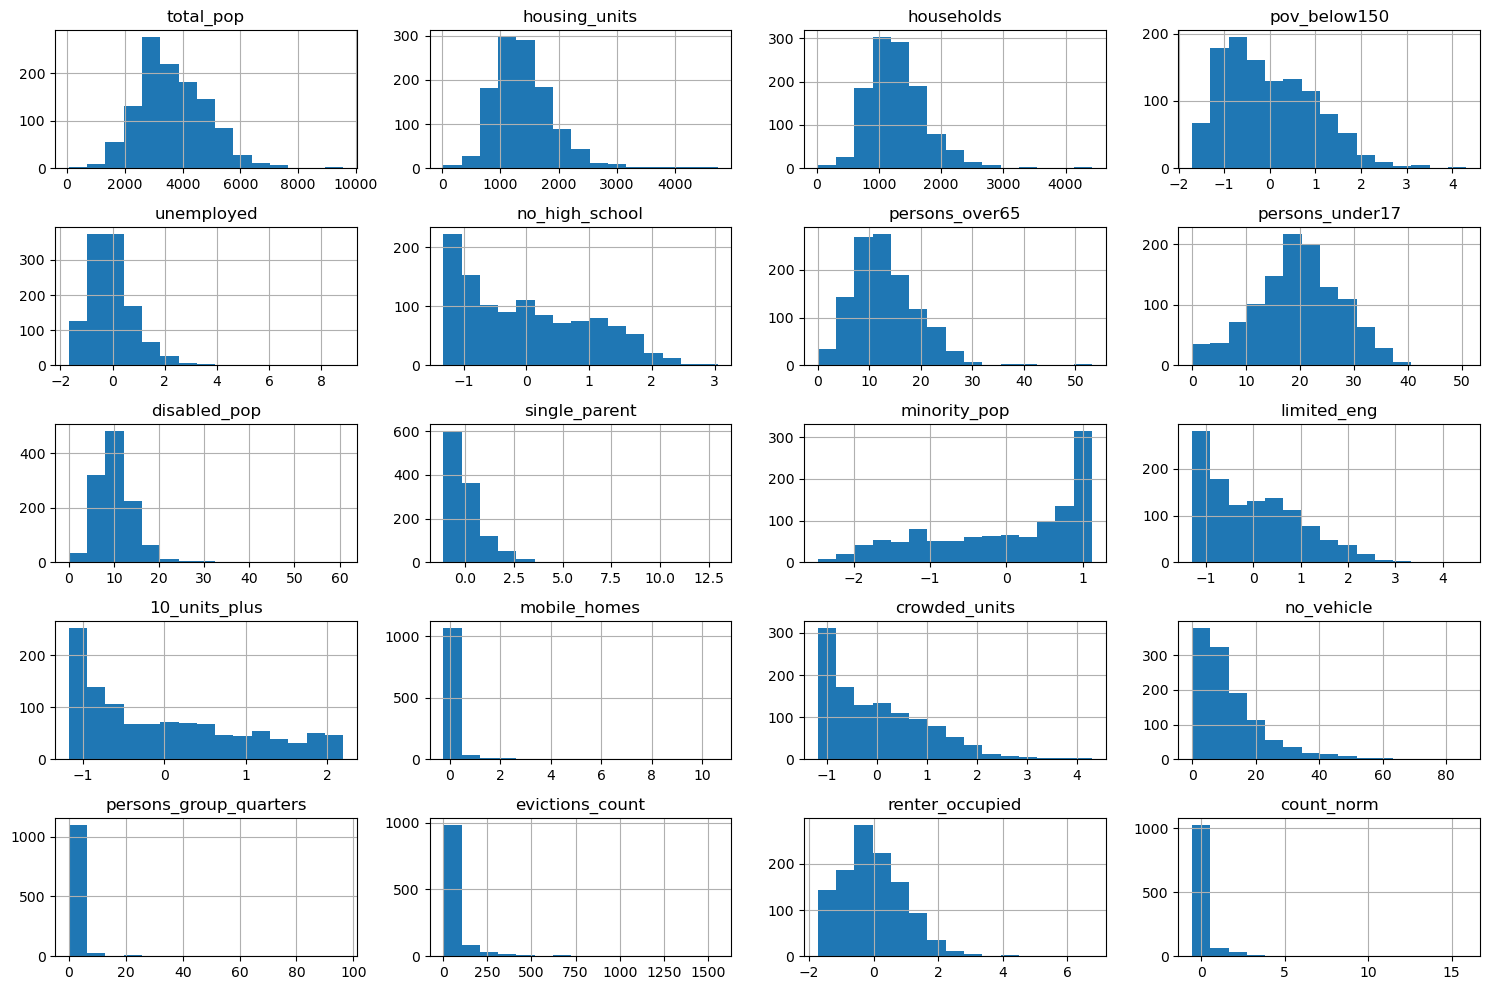

In [70]:
gdf_ct.hist(bins=15,figsize=(15,10))
plt.tight_layout()
plt.show()

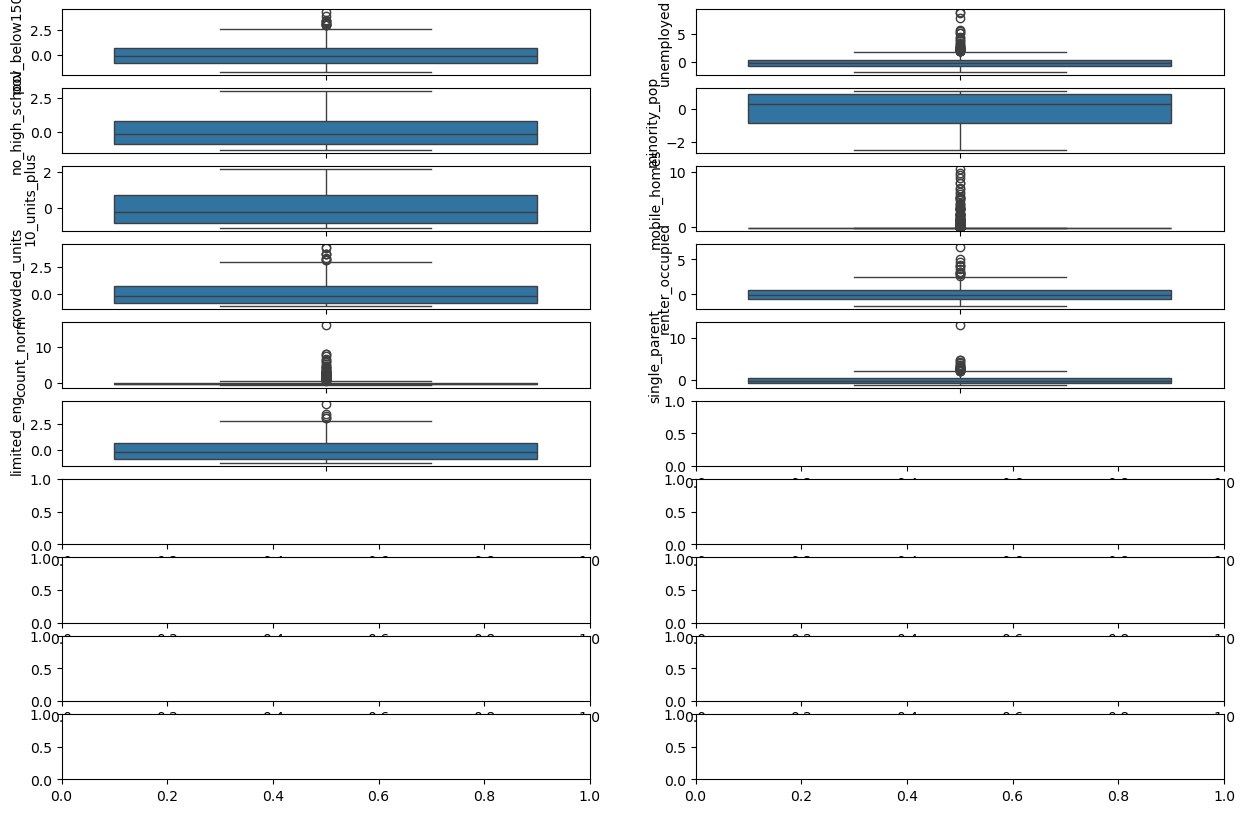

In [71]:
fig, ax = plt.subplots(10,2,figsize=(15,10))
ax = ax.flatten()

for i, var in enumerate(gdf_ct[census_vars]):
    sns.boxplot(y=var,data=gdf_ct,ax=ax[i])
   
plt.show()

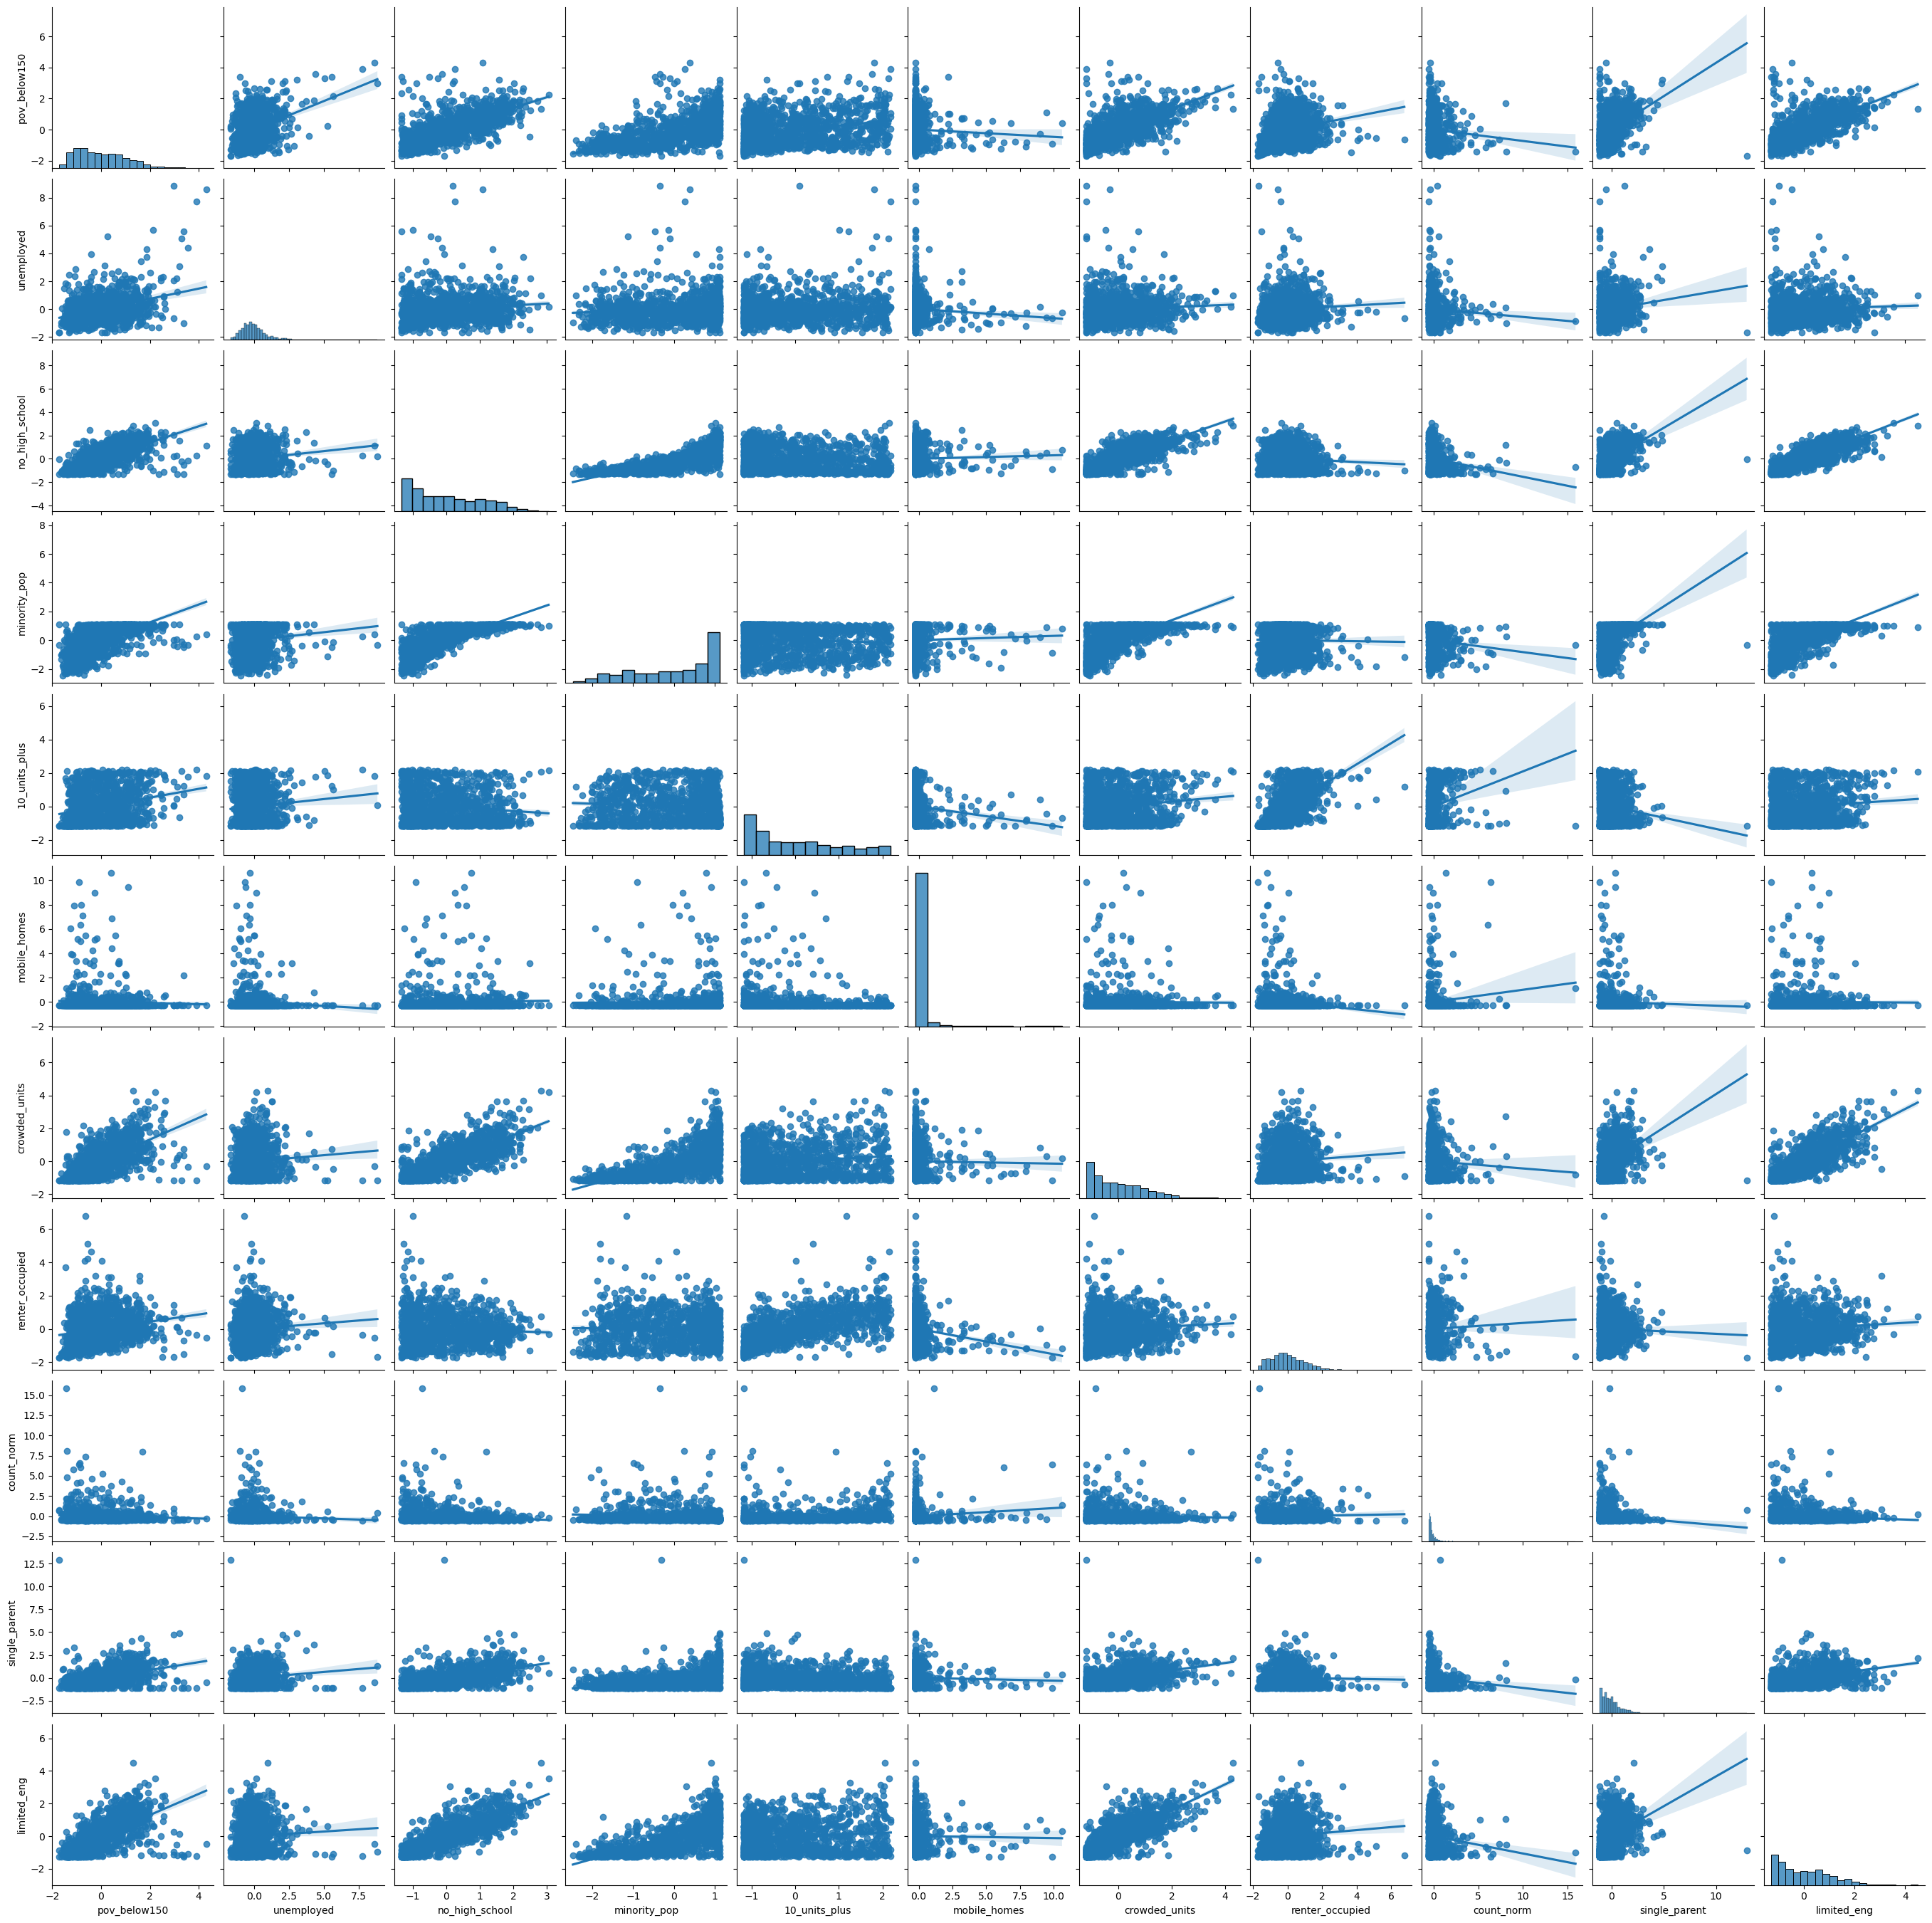

In [72]:
sns.pairplot(gdf_ct[census_vars],kind='reg')
plt.show()

In [73]:
config = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [
        {
          "dataId": [
            "evictions"
          ],
          "id": "sreoedtdg",
          "name": [
            "Notice Date"
          ],
          "type": "timeRange",
          "value": [
            1598918400000,
            1601078400000
          ],
          "enlarged": True,
          "plotType": "histogram",
          "yAxis": None
        }
      ],
      "layers": [
        {
          "id": "y8t676q",
          "type": "grid",
          "config": {
            "dataId": "evictions",
            "label": "Point",
            "color": [
              34,
              63,
              154
            ],
            "columns": {
              "lat": "latitude",
              "lng": "longitude"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "worldUnitSize": 0.5,
              "colorRange": {
                "name": "ColorBrewer RdYlGn-6",
                "type": "diverging",
                "category": "ColorBrewer",
                "colors": [
                  "#1a9850",
                  "#91cf60",
                  "#d9ef8b",
                  "#fee08b",
                  "#fc8d59",
                  "#d73027"
                ],
                "reversed": True
              },
              "coverage": 1,
              "sizeRange": [
                0,
                500
              ],
              "percentile": [
                0,
                100
              ],
              "elevationPercentile": [
                0,
                100
              ],
              "elevationScale": 20.9,
              "colorAggregation": "count",
              "sizeAggregation": "count",
              "enable3d": True
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": None,
            "colorScale": "quantize",
            "sizeField": None,
            "sizeScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "evictions": [
              {
                "name": "Notice Date",
                "format": None
              },
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 24,
      "dragRotate": True,
      "latitude": 33.837184166330836,
      "longitude": -118.46478962372794,
      "pitch": 50,
      "zoom": 9,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

In [74]:
from keplergl import KeplerGl
map = KeplerGl(height=600, width=800, data={'evictions':evics},config=config)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/opt/conda/lib/python3.11/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['evictions'], 'id': 'sreoedt…

### Summary of exploration

So it looks as though the data is not normally distributed across multiple variables and several variables have high degrees of multicollinearity. The low numbers of mobile homes and group quarters also seem to skew the data. I'm not entirely sure how to address these but will return to this. 

## COVID Rent Protections and timeline of evictions

In [75]:
# Convert notice date to datetime format
evics['notice_date_dt'] = pd.to_datetime(evics['Notice Date'], format='%m/%d/%y')

# Make sure there aren't any from outside 2023
evics = evics[evics['notice_date_dt'].dt.year >= 2023 ]

# Create a dataframe to hold eviction counts per day
address_count_grpd = evics.value_counts(['notice_date_dt']).reset_index(name='count')
address_count_grpd


/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,notice_date_dt,count
0,2023-03-08,1666
1,2023-04-05,1640
2,2023-04-06,1549
3,2023-05-04,1494
4,2023-04-07,1448
...,...,...
341,2023-12-25,1
342,2023-01-09,1
343,2023-01-08,1
344,2023-01-06,1


### Timeline of evictions for 2023

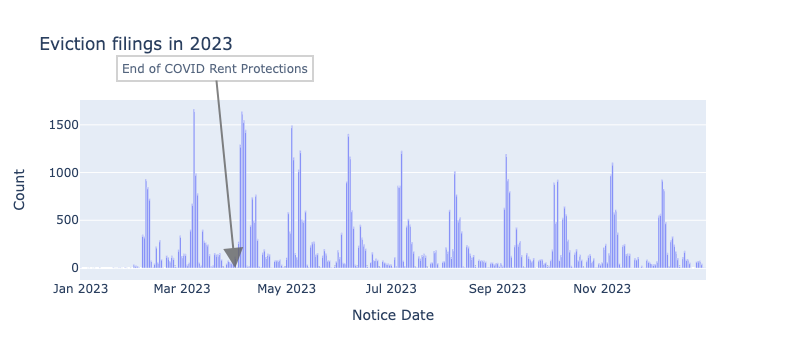

In [76]:
fig_date_year = px.bar(
    address_count_grpd,
    x = 'notice_date_dt',
    y='count',
    text='count',
    labels={
        'notice_date_dt':'Notice Date',
        'count':'Count'
    },
    title='Eviction filings in 2023',
    
)
fig_date_year.add_annotation(x='2023-04-01', y=0,
            text="End of COVID Rent Protections",
            showarrow=True,
            arrowhead=2,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=-20,
            ay=-200,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ffffff",
            opacity=0.8)
fig_date_year.show()

## Spatial Analysis

### Calculate spatial weights

In [77]:
# Generate W from the GeoDataFrame
w = KNN.from_dataframe(gdf_ct,geom_col='geometry',k=8)
# Row-standardization
w.transform = "R"
gdf_ct["w_count"] = libpysal.weights.lag_spatial(w, gdf_ct['count_norm'])

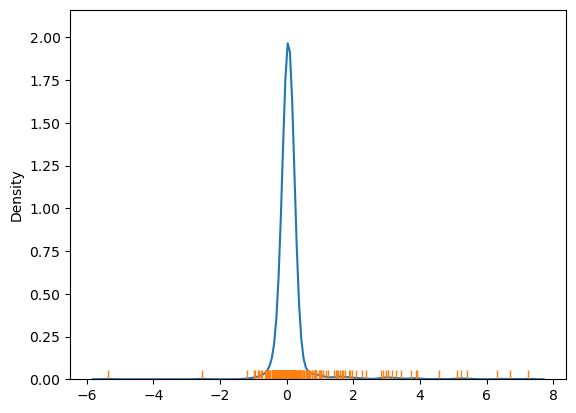

In [78]:
lisa = esda.moran.Moran_Local(gdf_ct['count_norm'], w)
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

### Create moran scatterplot

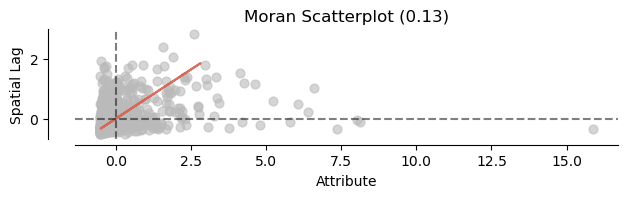

In [79]:
# Set y to list of normalized eviction count
y = gdf_ct['count_norm']

# Initialize moran plot and then graph
moran = Moran(y,w)
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

## Our Moran Scatterplot above shows that our data shows clustering. This means that either low eviction areas per 1000 occupied units are surrounded by low eviction areas per 1000 occupied units or high eviction areas per 1000 occupied units are surround by high eviciton areas per 1000 occupied units

### Plot Reference Distribution

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.13', ylabel='Density'>)

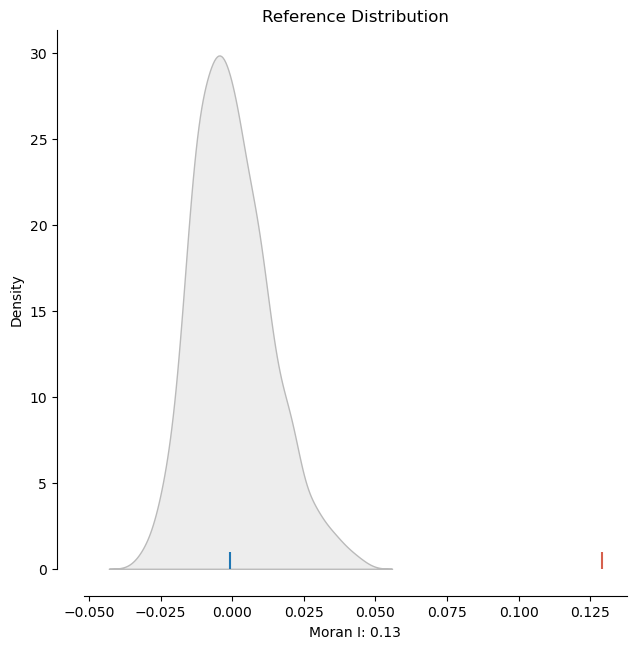

In [80]:
plot_moran_simulation(moran,aspect_equal=False)

## In reference to the simulation of our data (shuffling of our data), on our right we see that there is clustering in our dataframe of evictions per 1000 occupied units

In [81]:
moran.p_sim

0.001

# Above we can see that we got a very small p-value meaning that with 99% confidence we can say that evictions per 1000  occupied units is spacially clustered per census tract in the city of Los Angeles

### Visualize weighted count vs original, normalized count

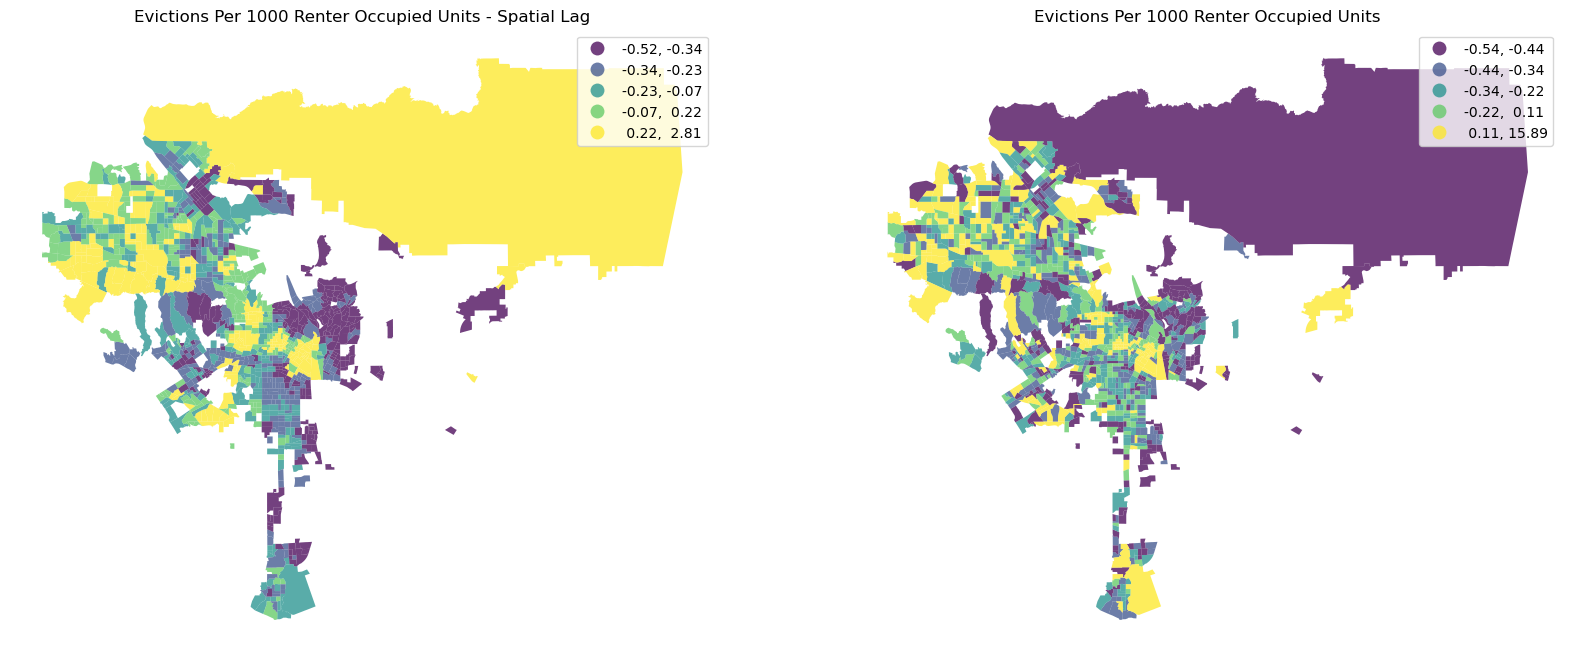

In [82]:
f, axs = plt.subplots(1,2,figsize=(20, 16))
ax1, ax2 = axs

gdf_ct.plot(
    column="w_count",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)

gdf_ct.plot(
    column="count_norm",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)

ax1.axis('off')
ax2.axis('off')
ax1.set_title('Evictions Per 1000 Renter Occupied Units - Spatial Lag')
ax2.set_title('Evictions Per 1000 Renter Occupied Units')
plt.show()

### Calculate local moran values, plot values, and visualize clusters

In [83]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, w)

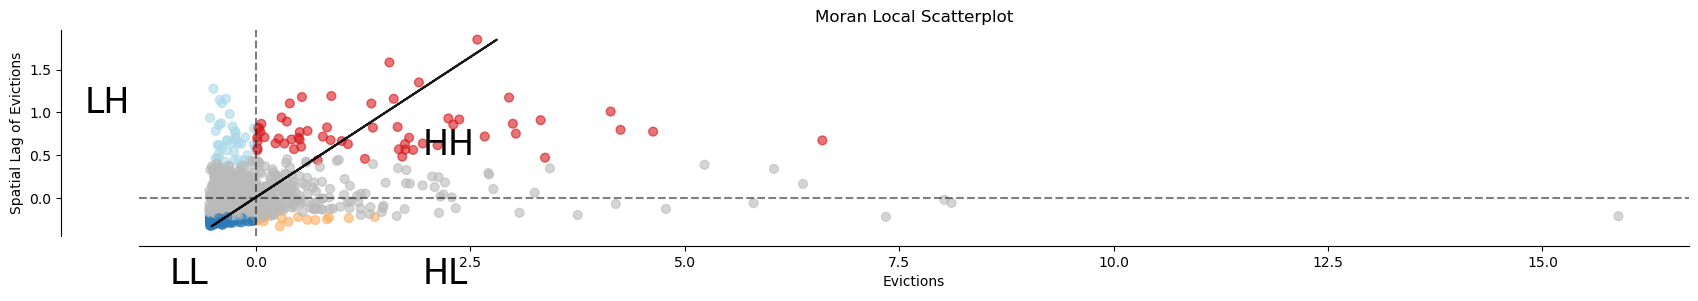

In [84]:
# Plot
fig,ax = plt.subplots(figsize=(20,20))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Evictions")
ax.set_ylabel('Spatial Lag of Evictions')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

## In the above scatterplot, each dot is a census tract. 
- For each <font color='red'>red</font> colored tract we are 95% confident that these tracts have high eviction counts per 1000 occupied units surrounded by other high eviction count tracts per 1000 occupied units. 
- For each light <font color='lightblue'>blue</font> colored tract we are 95% confident that these tracts have a low eviction count per 1000 occupied units surrounded by high eviction count tracts per 1000 occupied units.
- For each <font color='orange'>orange</font> tract we are 95% confident that these tracts have a high eviction count per 1000 occupied units surrounded by low eviction count tracts per 1000 occupied units.
- For the <font color='darkblue'> blue</font> census tracts we are 95% confident that they have low eviction count per 1000 occupied units surrounded by low eviction count tracts per 1000 occupied units.

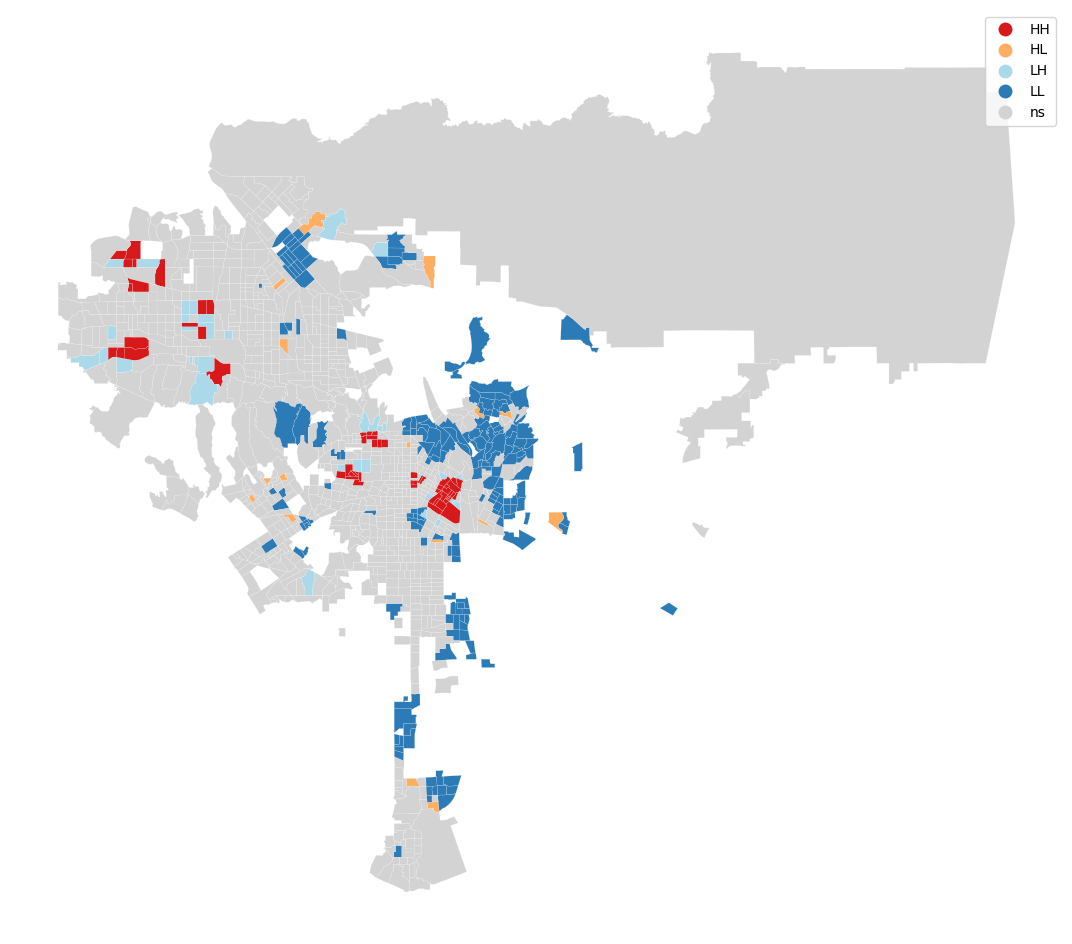

In [85]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf_ct, p=0.05, ax=ax)
plt.show()

## Looking at this map we are 95% confident that Westlake, Downtown and some areas in the valley have a high eviction counts per 1000 occupied units surrounded by areas of other high evictions counts per 1000 occupied units.
- In the __Valley__ we are 95% confidentthat there are areas that have a low eviction count per 1000 occupied units surrounded by areas that have a high eviction count per 1000 occupied units
- __East of Los Angeles__ we have an area where we are 95% confident that has a high eviction count per 1000 occupied units surrounded by areas that have a low eviction count per 1000 occupied units
- We are also 95% confident that __West Hollywood__ has a high eviction count per 1000 occupied units surrounded by areas that have a high eviction count per 1000 occupied units
- Finally, we are 95% confident that areas in __South of Los Angeles__ have a low eviction count per 1000 occupied units surrounded by areas that hahve a low eviction count per 1000 occupied units

And create a map comparing different p-values

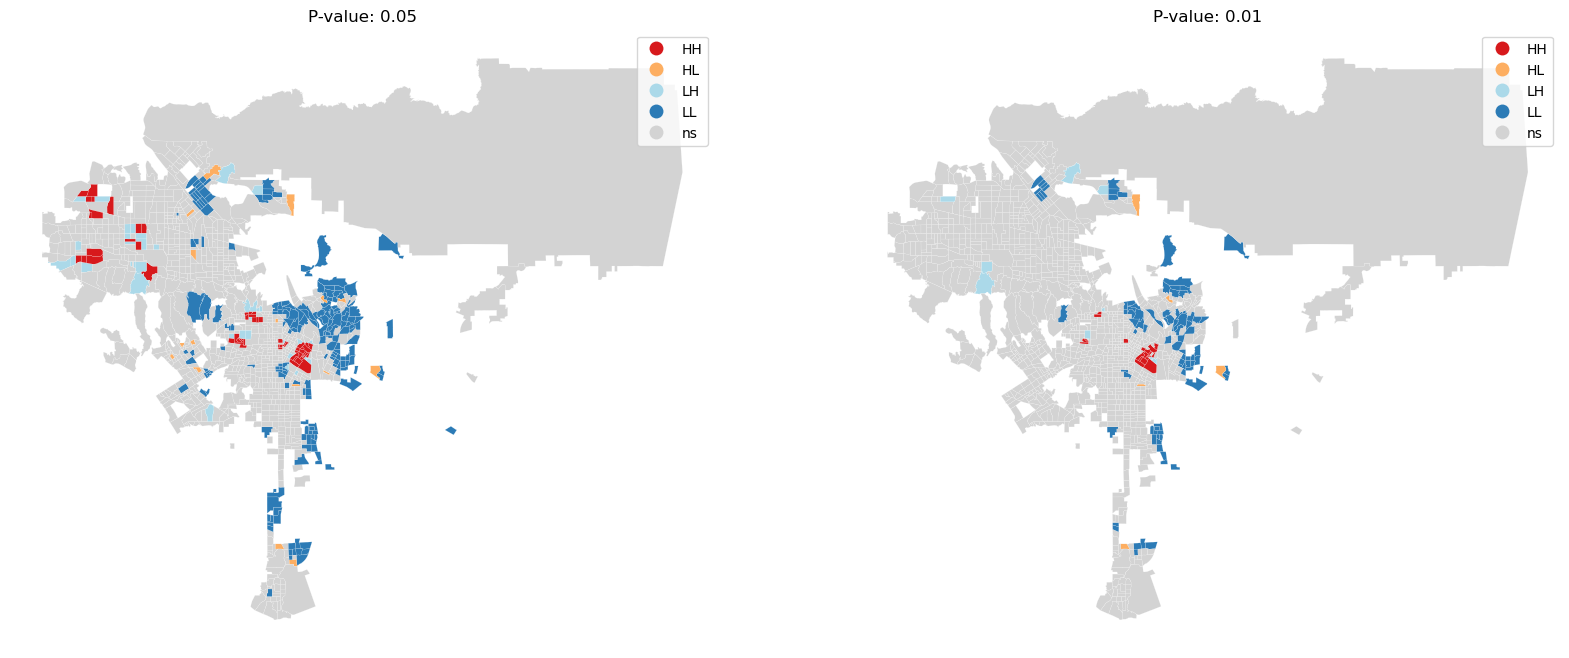

In [86]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, gdf_ct, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, gdf_ct, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

## Increasing our confidence to 99% (as shown on the right map) we can see that many tracts are no longer highlighted

/tmp/ipykernel_367/586694209.py:8: FutureWarning:

'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)



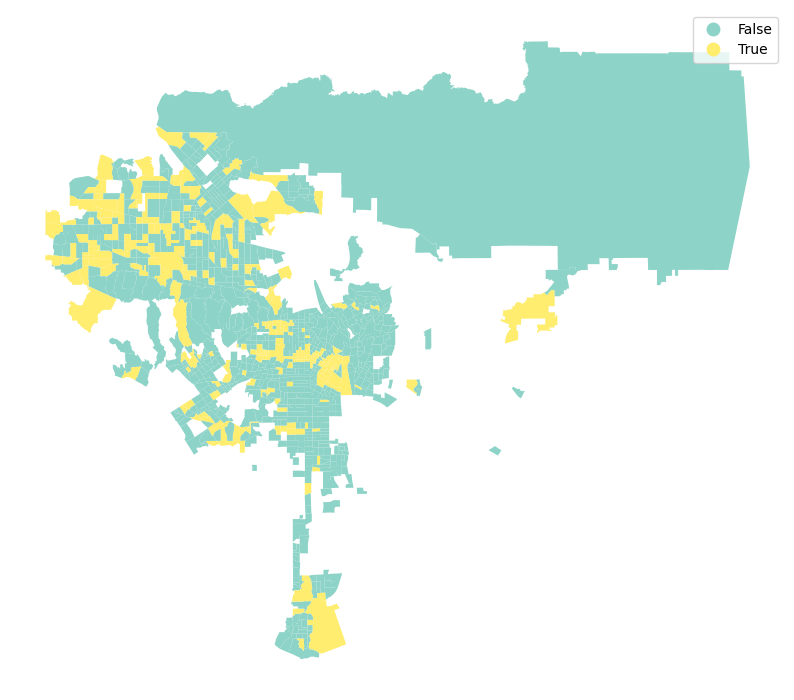

In [87]:
# Create a binary variable to subset 'high' eviction rate tracts and 'low' eviction rate tracts
evic_mean = gdf_ct['count_norm'].mean()
gdf_ct['evic_risk'] = gdf_ct['count_norm']>evic_mean

# Visualize the new variable
f, ax = plt.subplots(1,figsize=(10,10))

gdf_ct.plot(
    ax=ax,
    column='evic_risk',
    categorical=True,
    legend=True,
    colormap='Set3',
)
ax.set_axis_off()
plt.show()

In [88]:
# Transform
w.transform = "O"
jc = esda.join_counts.Join_Counts(gdf_ct['evic_risk'], w)
jc_table = pd.DataFrame(data=[
    [jc.bb,jc.bw,jc.ww,(jc.bb+jc.bw+jc.ww)],
    [jc.mean_bb,jc.mean_bw,'na','na'],
    [jc.p_sim_bb,jc.p_sim_bw,'na','na']],
    columns= ['Low-Low','Low-High','High-High','Sum'],index=['Actual', 'Predicted', 'p-values'])
jc_table

,Low-Low,Low-High,High-High,Sum
Actual,463.000000,1354.500000,2790.5,4608.0
Predicted,281.538539,1716.915916,na,na
p-values,0.001000,1.000000,na,na


In [89]:
gdf_ct = gdf_ct.dropna()

In [90]:
gdf_ct.shape

(1152, 24)

In [94]:
dep_variables = [
    'pov_below150',
    'unemployed',
    'no_high_school',
    'minority_pop',
    'mobile_homes',
    'crowded_units',
    'renter_occupied',
    'single_parent',
    'limited_eng'
 ]

def fml(dep_vars,ind_vars):
    var_str = ind_vars + " ~ " + " + ".join(dep_vars)
    return var_str


In [95]:
vars = fml(dep_variables,'count_norm')

y, X = dmatrices(vars,gdf_ct,return_type='dataframe')

X = add_constant(X)
model = sm.GLM(y,X,family=sm.families.Gaussian())
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             count_norm   No. Observations:                 1152
Model:                            GLM   Df Residuals:                     1142
Model Family:                Gaussian   Df Model:                            9
Link Function:               Identity   Scale:                         0.94903
Method:                          IRLS   Log-Likelihood:                -1599.5
Date:                Mon, 18 Mar 2024   Deviance:                       1083.8
Time:                        05:58:31   Pearson chi2:                 1.08e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06052
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.145e-16      0.029  -3.

## Above we have a built a model to assess how the variables interact with our eviction count per 1000 occupied units. While most of our variables appear to not be statistically significant in our model we will still include them and explain them. 
- The coefficient .0562 suggests that a change in __higher poverty rate__ results in higher evictions count per 1000 occupied units. Due to our confidence interval containing 0, we can conclude that this variable is not statistically significant
- The coefficient -.0388 suggests that a change in __unemployment__ does not result in a change in higher evictions counts. Due to our confidence interval containing 0, we can conclude that this variable is not statistically significant 
- The coefficient -.3833 suggests that a a greater __population with no high school education__ does not result in a change in higher eviction counts. Due to the confidence interval containing 0 therefore, we can conclude it is statistically significant.
- The coefficient .0848 suggests that an increase __minority population__ results in a higher eviction count. Due to our confidence interval containing 0, we can conclude that this variable is not statistically significant.
- The coefficient .1105 suggests that an increase in __mobile homes__ reuslts in a higher eviction count per 1000 occupied units. Due to the confidence interval not containing 0, we can conclude it is statistically significant.
- The coefficient .2050 suggests that an increase in __crowded units__ results in a higher eviction count. Due to our confidence interval not containing 0, we can conclude that this variable is statistically significant
- The coefficient .0025 suggests that an increase in __renter occupied units__ results in a higher eviction count per 1000 occupied units. Due to our confidence interval containing 0, we can conclude that this is not statistically significant
- The coefficient -.0380 suggests that an increase in __single parent occupants__ does not result in an increase eviction counts per 10000 occupied untis. Due to our confidence interval containing 0, we can conclude that this variable is not statistically significant
- The coefficient -.0239 suggests that an increase population with __limited english__ does not result in a higher eviction count per 1000 occupied units. Due to our confidence interval containing 0, we can conclude that this is not statistically significant

In [96]:

bayes_model = bmb.Model(formula=fml,data=gdf_ct,dropna=True)

bayes_model.prior_predictive
# model_fitted = bayes_model.fit()
# az.plot_trace(model_fitted, compact=True)
# az.summary(model_fitted)


ValueError: '.formula' must be instance of 'str' or 'bambi.Formula'